# Time series Causal discovery Workshop

In the realm of predictive maintenance, understanding the dynamics of Root Cause Analysis (RCA) over time is crucial for effective decision-making and preemptive action. This study aims to delve into the intricate relationship between time and RCA, particularly within the context of a safety system employing the 2oo3 (two out of three) redundancy scheme.



## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
from collections import defaultdict
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmiknn import CMIknn

from tigramite.lpcmci import LPCMCI
from tigramite.data_processing import DataFrame
import tigramite.plotting as tp
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from networkx import DiGraph
from graphviz import Digraph



## Data Greneration

Below, a function that generates a synthetic dataset for a 3 channel safety system.

The dataset under examination comprises a time series representation of three channels within the safety system. Notably, the point of incipient failure (PoIF) materializes precisely at the midpoint of the timeline, providing a critical juncture for analysis, through one of the channels experiencing a random failure, introducing an element of unpredictability into the system. By exploring how time influences the RCA process in such conditions, valuable insights can be gleaned to enhance predictive maintenance strategies and bolster system reliability.

In [2]:

def DA_GenData(N):
    """ Generate synthetic dataset for a 3 channel redundancy saftey system.
        
    Args:
        N (int): number of instances.

    Returns:
        data (numpy int tensor): [N,Time,Variable], [N,100,4].
            Variable: failure, ch1, ch2, ch3
        rc (numpy int array): Root causes: 1,2,3.
    """
    np.random.seed(42)
    T = 100
    data = 0.05*np.random.randn(N,T,4)
    labels = np.random.random_integers(1,3,N)
    alarm_binary = np.zeros((N, T))  # Initialize binary alarm column
    for n in range(N):
        for t in range(2,T):
            data[n,t,1] += 0.4*data[n,t-1,2] + 0.4*data[n,t-2,3] 
            data[n,t,2] += 0.4*data[n,t-1,1] + 0.4*data[n,t-1,3] 
            data[n,t,3] += 0.4*data[n,t-1,2] + 0.4*data[n,t-2,1] 
            if t > int(T/2):
                data[n,t,labels[n]] += 0.5*np.abs(np.random.randn())
            data[n,t,0] = np.min([1.0, np.abs(0.2*data[n,t,1] +\
                                             0.2*data[n,t,2] +\
                                             0.2*data[n,t,3])])
            
    # Transform alarm column into binary column
            if data[n, t, 0] > 0:  # If alarm is present
                alarm_binary[n, t] = 1

    data = (20*data+10).astype(int)
    data[:,:,0] -= 10
    for n in range(N):
        for t in range(T):
            if data[n,t,0] < 0:
                data[n,t,0] = 0
            if data[n,t,0] > 10:
                data[n,t,0] = 10
    return data,labels


def DA_Plot(data, labels):
    """ Plot dataset instance by instance.
        
    Args:
        data (numpy tensor): [N,Time,Variable]
        labels (numpy array): Root causes: 1,2,3.
    """
    datatime = np.arange(100)
    for i in range(data.shape[0]):
        plt.figure()
        plt.plot(datatime,data[i,:,0], 'k', label="Alarm Level")
        plt.plot(datatime,data[i,:,1], 'r', label="Channel 1")
        plt.plot(datatime,data[i,:,2], 'g', label="Channel 2")
        plt.plot(datatime,data[i,:,3], 'b', label="Channel 3")
        plt.legend(loc="upper left")
        plt.title("Failure on Channel: " + str(labels[i]))
        plt.xlabel("Time")
        plt.ylabel("Message Count")
        plt.savefig('data_plot.png')
        plt.show()
        


In [3]:
import pandas as pd

## Generating the data
data,labels = DA_GenData(100)
#DA_Plot(data,labels)

## Naming columns and saving data

columns = ["alarm","ch1_t","ch2_t","ch3_t"]

# Reshaping the data to (N*t, 4)
flattened_data = data.reshape(-1, 4)  # -1 in reshape allows numpy to calculate the necessary size to maintain the same total number of elements
print(len(labels), len(data))

df = pd.DataFrame(flattened_data, columns= columns)
df.to_csv('data.csv', index=False)


100 100


/tmp/ipykernel_2859442/2431333724.py:15: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  labels = np.random.random_integers(1,3,N)


## Ground Truth graph

The function aims to create a directed graph (Digraph) representing the relationships between variables in the data generation process. Nodes are added to represent channels (ch1_t, ch2_t, ch3_t) at different time points (t, t1, t2), as well as a failure node. Edges are added to depict dependencies between these variables, illustrating how the state of one variable influences another. Additionally, the graph is converted to a NetworkX graph for further analysis.


In [4]:
dot = Digraph(comment='Variable Relationships in Data Generation')

# Adding nodes for channels and failure
dot.node('ch1_t', 'ch1_t')
dot.node('ch2_t', 'ch2_t')
dot.node('ch3_t', 'ch3_t')
dot.node('ch1_t1', 'ch1_t1')
dot.node('ch2_t1', 'ch2_t1')
dot.node('ch3_t1', 'ch3_t1')
dot.node('ch1_t2', 'ch1_t2')
#dot.node('ch2_t2', 'ch2_t2')
dot.node('ch3_t2', 'ch3_t2')
dot.node('alarm', 'alarm')

"""# Adding edges showing dependencies
dot.edge('CH2_t1', 'CH1_t')
dot.edge('CH3_t2', 'CH1_t')
dot.edge('CH1_t1', 'CH2_t')
dot.edge('CH3_t1', 'CH2_t')
dot.edge('CH2_t', 'failure')
dot.edge('CH1_t2', 'CH3_t')
dot.edge('CH3_t', 'Alarm')
dot.edge('CH2_t1', 'CH3_t')
dot.edge('CH1_t', 'failure')

"""

#dot = nx.DiGraph()

nodes = ['alarm','ch1_t', 'ch2_t', 'ch3_t',  
         'ch1_t1', 'ch2_t1','ch3_t1',
         'ch1_t2', 'ch3_t2', 
        ]
# G.add_nodes_from()
"""for n in nodes:
    dot.add_node(n)"""

dot.edge('ch2_t1', 'ch1_t')
dot.edge('ch3_t2', 'ch1_t')
dot.edge('ch1_t1', 'ch2_t')
dot.edge('ch3_t1', 'ch2_t')
dot.edge('ch1_t2', 'ch3_t')
dot.edge('ch2_t1', 'ch3_t')
dot.edge('ch1_t','alarm')
dot.edge('ch2_t','alarm')
dot.edge('ch3_t','alarm')


# Render the graph to a file
dot.render('variable_relationships2', format='png', cleanup=True)


'variable_relationships2.png'

The following ground-truth graph illustrate the underlying data generation process. 

![alt text](variable_relationships2.png)

Variables : 

- Channel variables : ch1_t, ch2_t and ch3_t.
- "Alarm" describe the evolution of the failure alarm level.



In [5]:
columns= ["alarm", "ch1_t", "ch2_t","ch3_t"]
df = pd.read_csv('data.csv')
flattened_data = df.values
np.shape(flattened_data)

(10000, 4)

## Graph and Timeserie Causal discovery using Tigramite PCMCI Algorithm

In [6]:
def run_causal_discovery_pcmci(df, final_columns_list, pvalue, filename='pcmci'):

    pcmci = PCMCI(dataframe=df, cond_ind_test=ParCorr(significance='analytic'), verbosity=0)
    res = pcmci.run_pcmciplus(tau_min=0, tau_max=2, pc_alpha=pvalue) 

    res['graph2'] = res['graph'].copy()
    #print(np.unique(res['val_matrix']))
    # Remove low MCI links using numpy
    #ind = np.where(res['val_matrix'] < 0.2)
    #res['graph2'][ind] = ''

    # Keep only directed edges
    #res['graph2'] = res['graph'].copy()
    #ind = np.where(res['graph2'] == 'o-o')
    #res['graph2'][ind] = ''

    # Remove conflictual links
    ind = np.where(res['graph2'] == 'x-x')
    res['graph2'][ind] = ''
    print(plt.get_backend())

    # Remove conflictual links
    """res['graph3'] = res['graph'].copy()
    ind = np.where(res['graph3'] == 'x-x')
    res['graph3'][ind] = ''
    print(plt.get_backend())"""

    # Plot time series graph
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=80)

    tp.plot_graph(graph=res['graph2'],
                  fig_ax=(fig, ax),
                  val_matrix=res['val_matrix'],
                  var_names= final_columns_list   ,
                  link_colorbar_label='MCI',
                  show_autodependency_lags=True,
                  #figsize= (20,20),
                  node_size=0.1)
    filename = "pcmci_directed" + f"{pvalue}"
    plt.savefig('./' + filename + '.png')
    plt.tight_layout()
    plt.show()

    # Plot time series graph
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=800)

    tp.plot_graph(graph=res['graph'],
                  fig_ax=(fig, ax),
                  val_matrix=res['val_matrix'],
                  var_names= final_columns_list   ,
                  link_colorbar_label='MCI',
                  show_autodependency_lags=True,
                  #figsize= (20,20),
                  node_size=0.1)
    filename = "pcmci_all" + f"{pvalue}"
    plt.savefig('./' + filename + '.png')
    plt.tight_layout()
    plt.show()

    return res #G


For pvalue 0.05 : 

module://matplotlib_inline.backend_inline


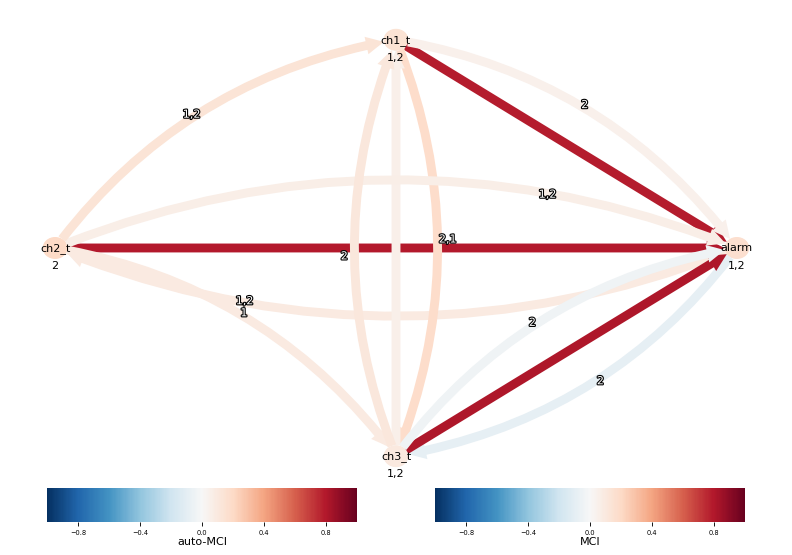

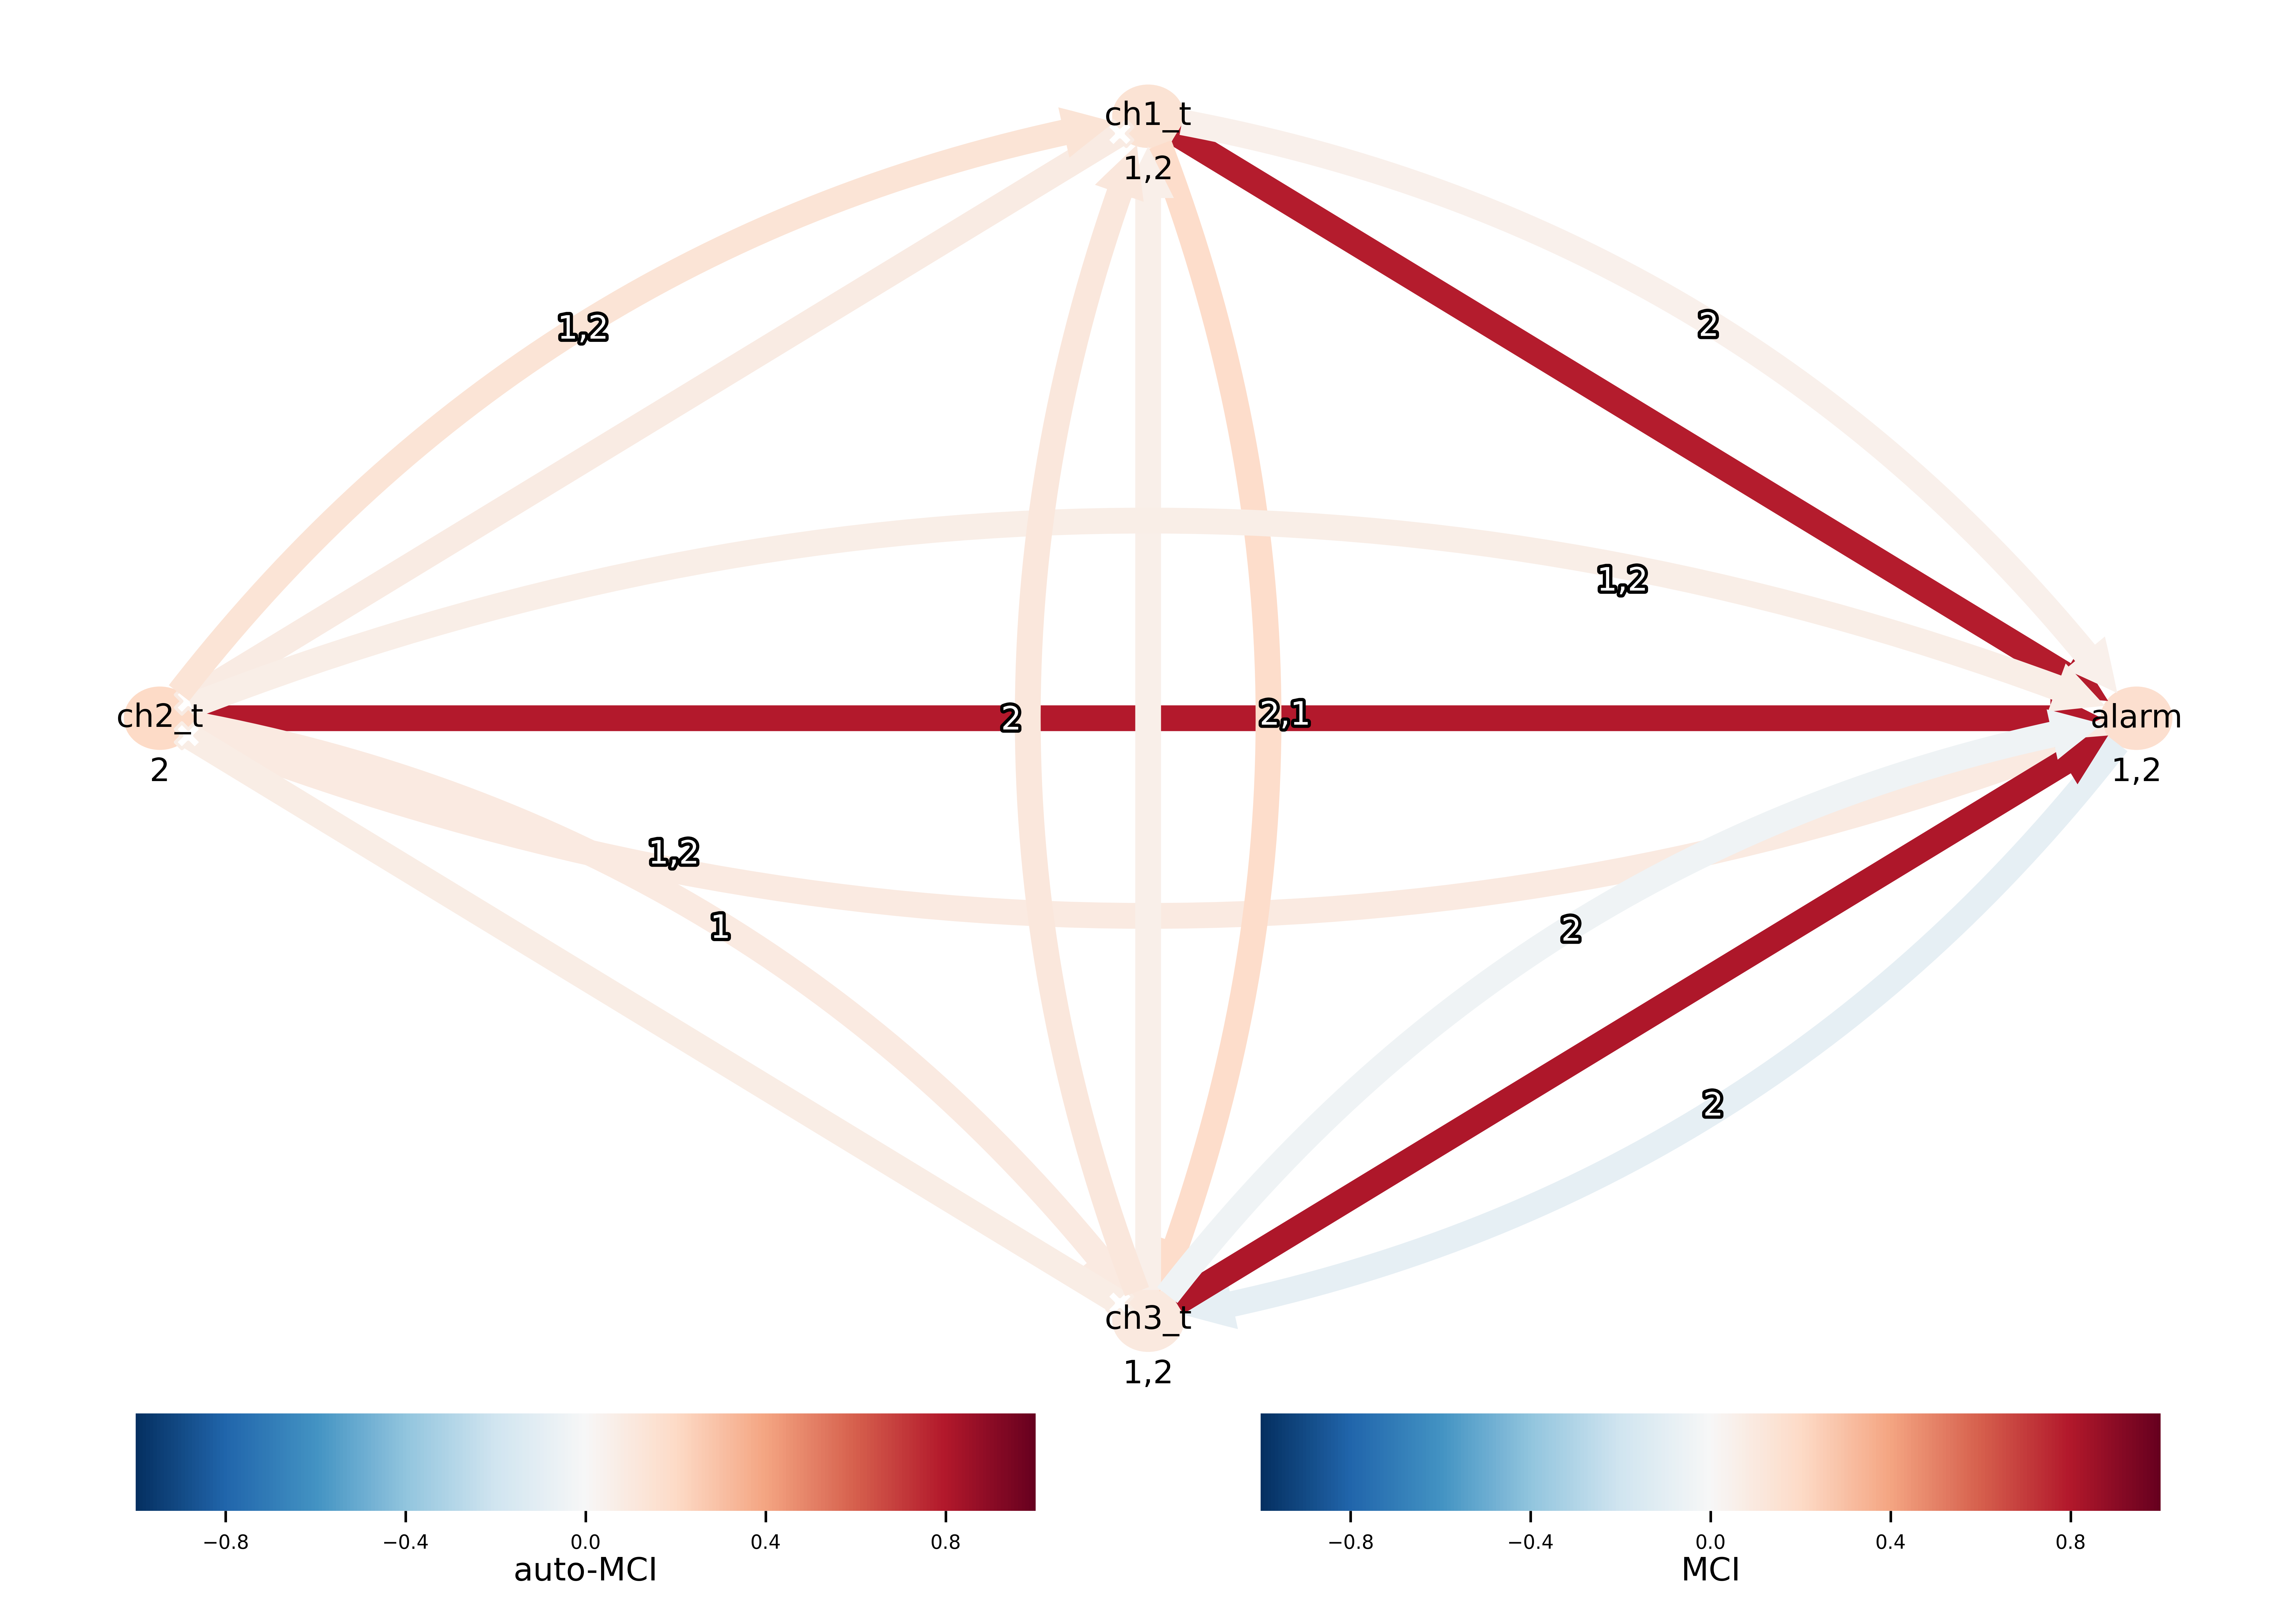


For pvalue 0.03 : 

module://matplotlib_inline.backend_inline


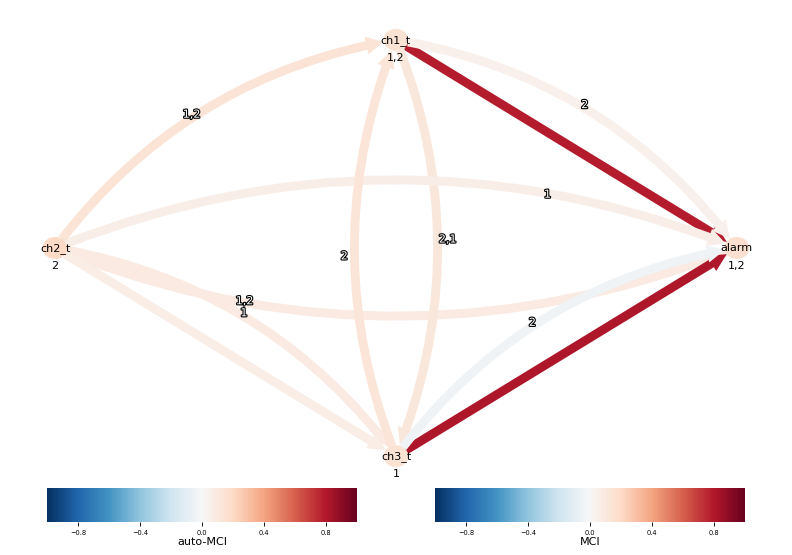

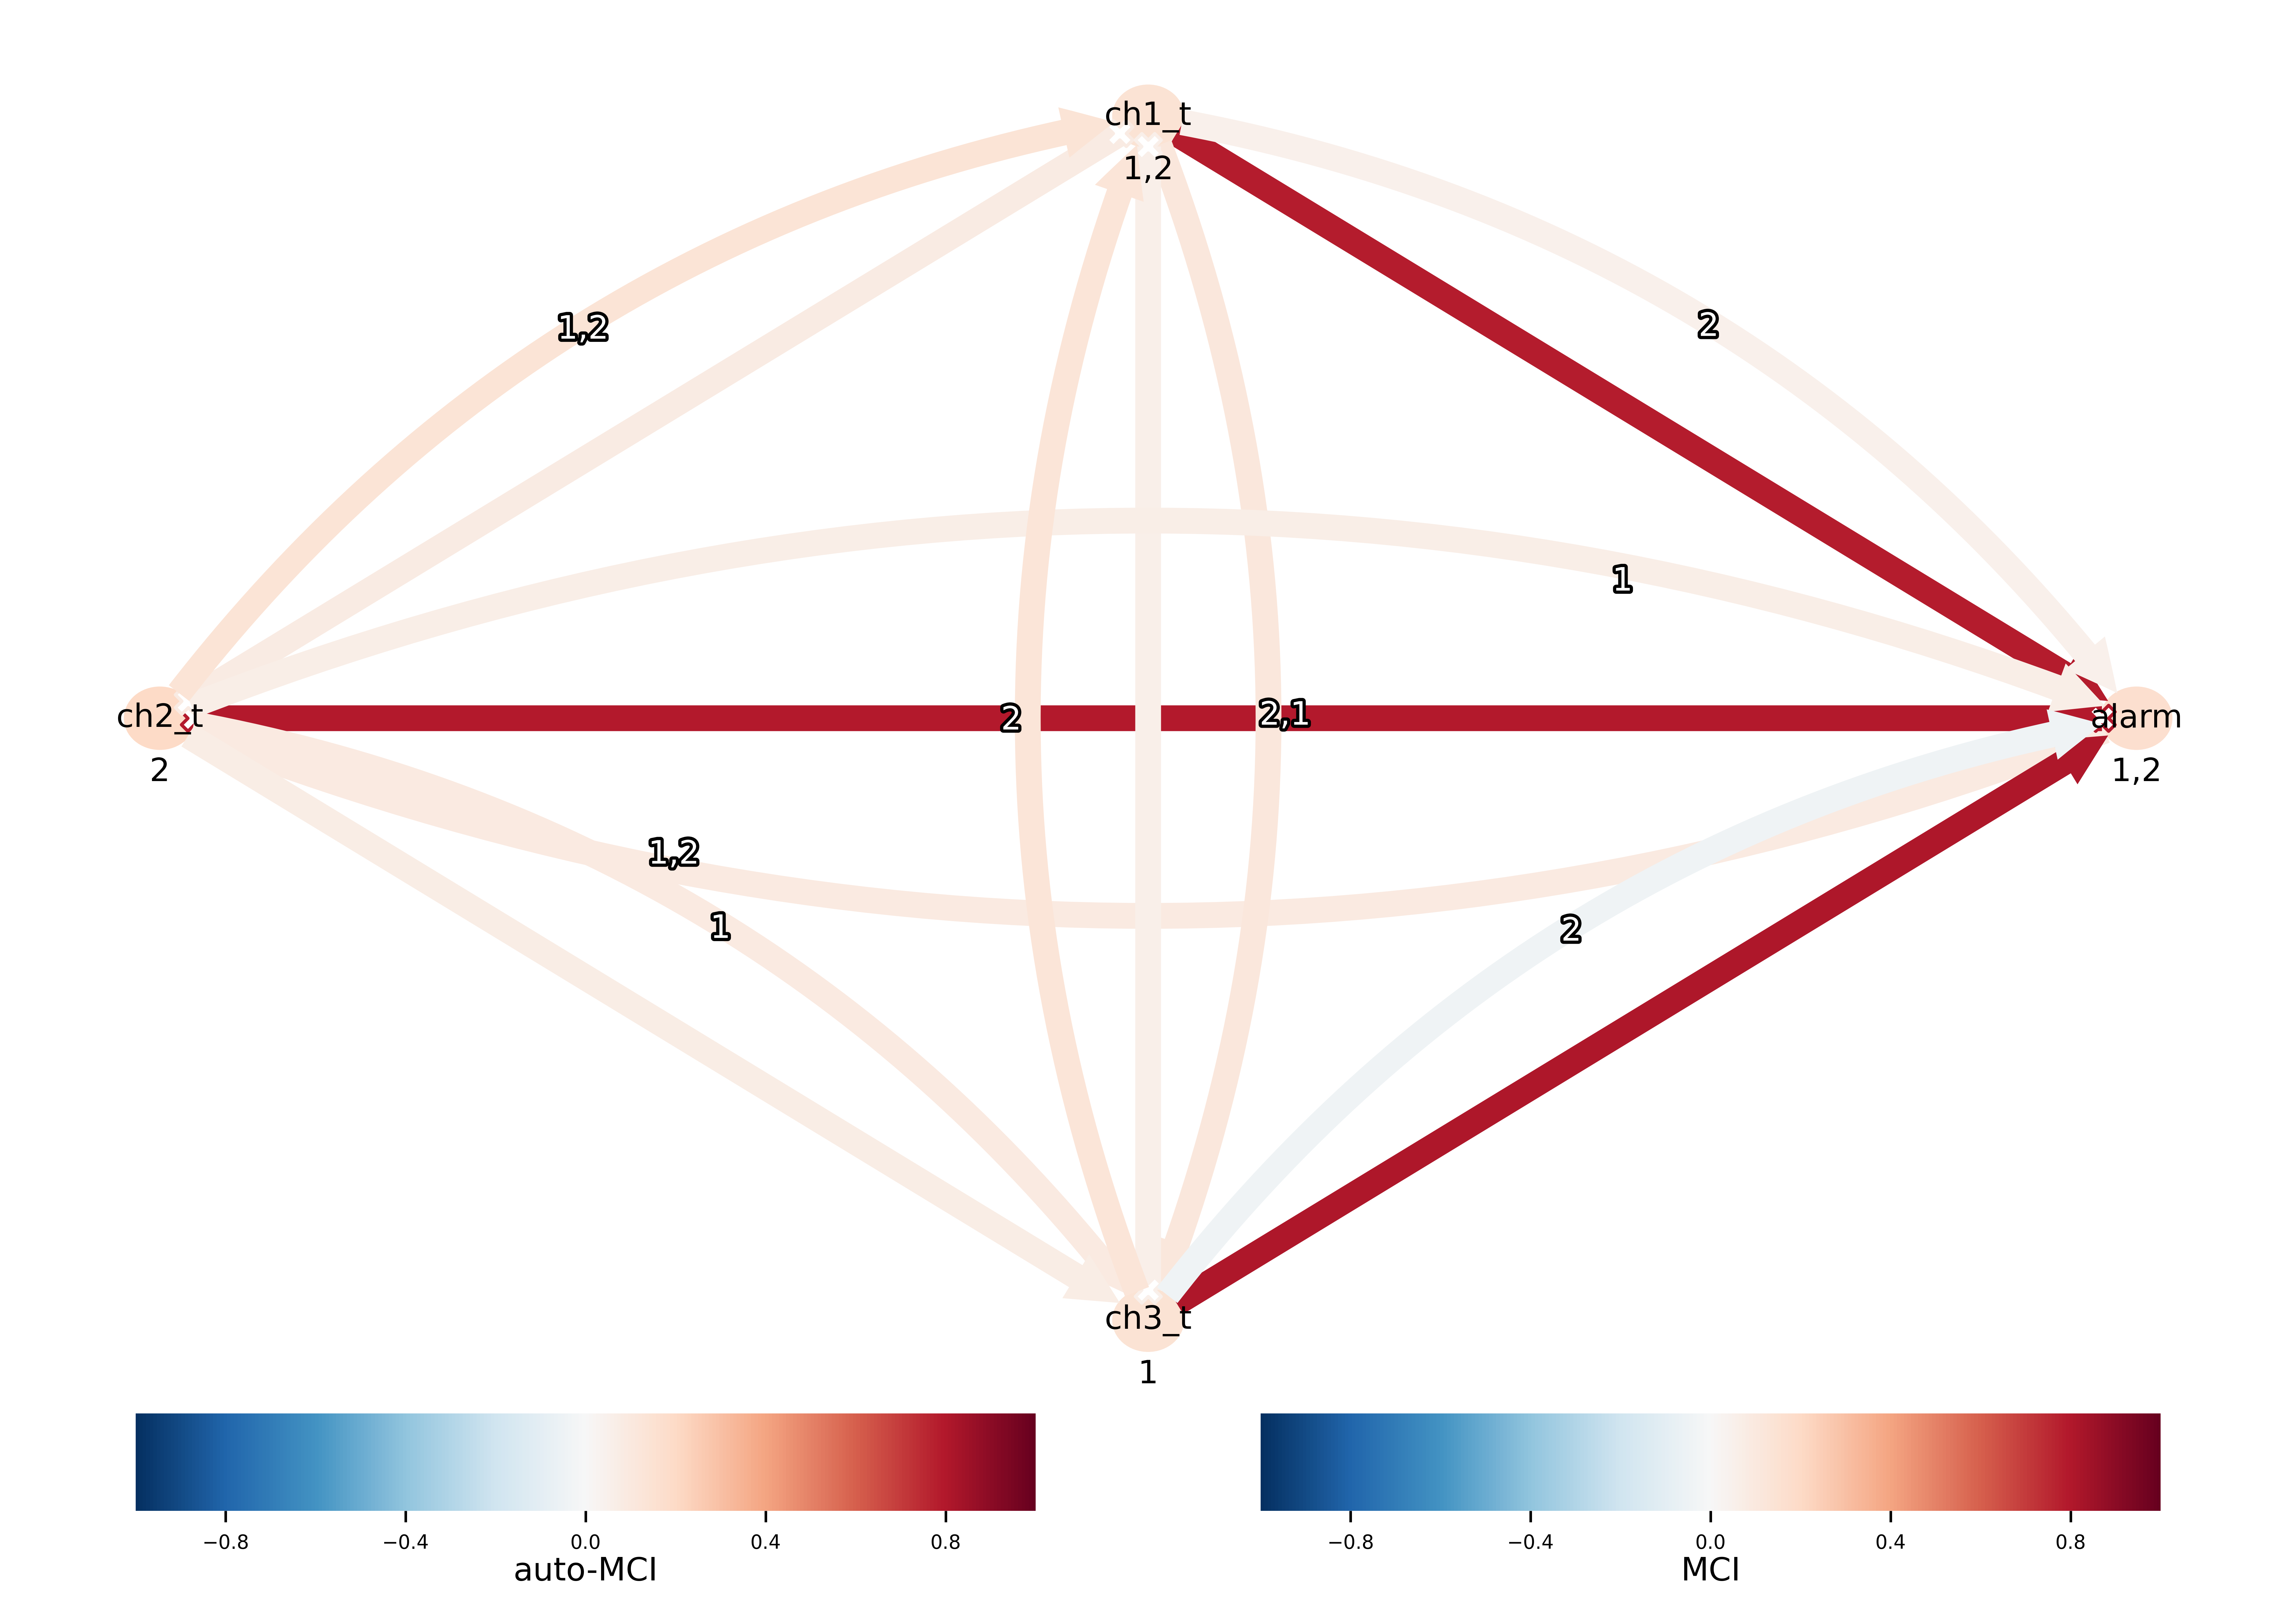


For pvalue 0.01 : 

module://matplotlib_inline.backend_inline


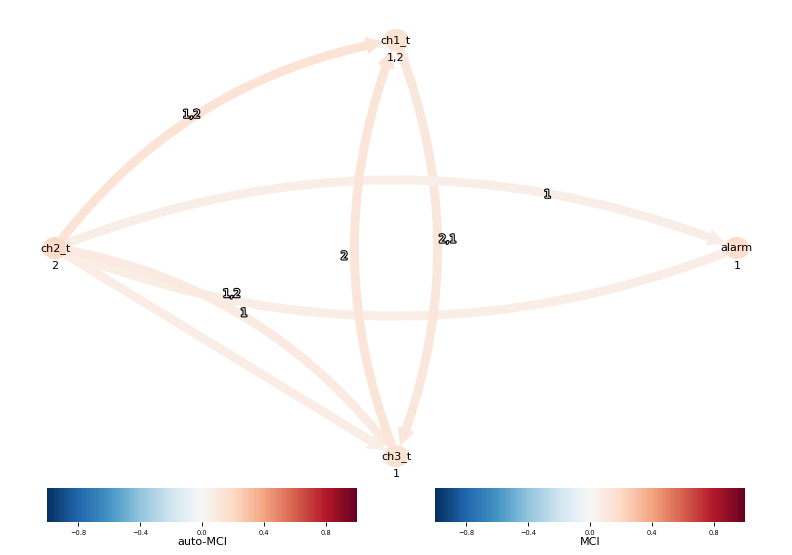

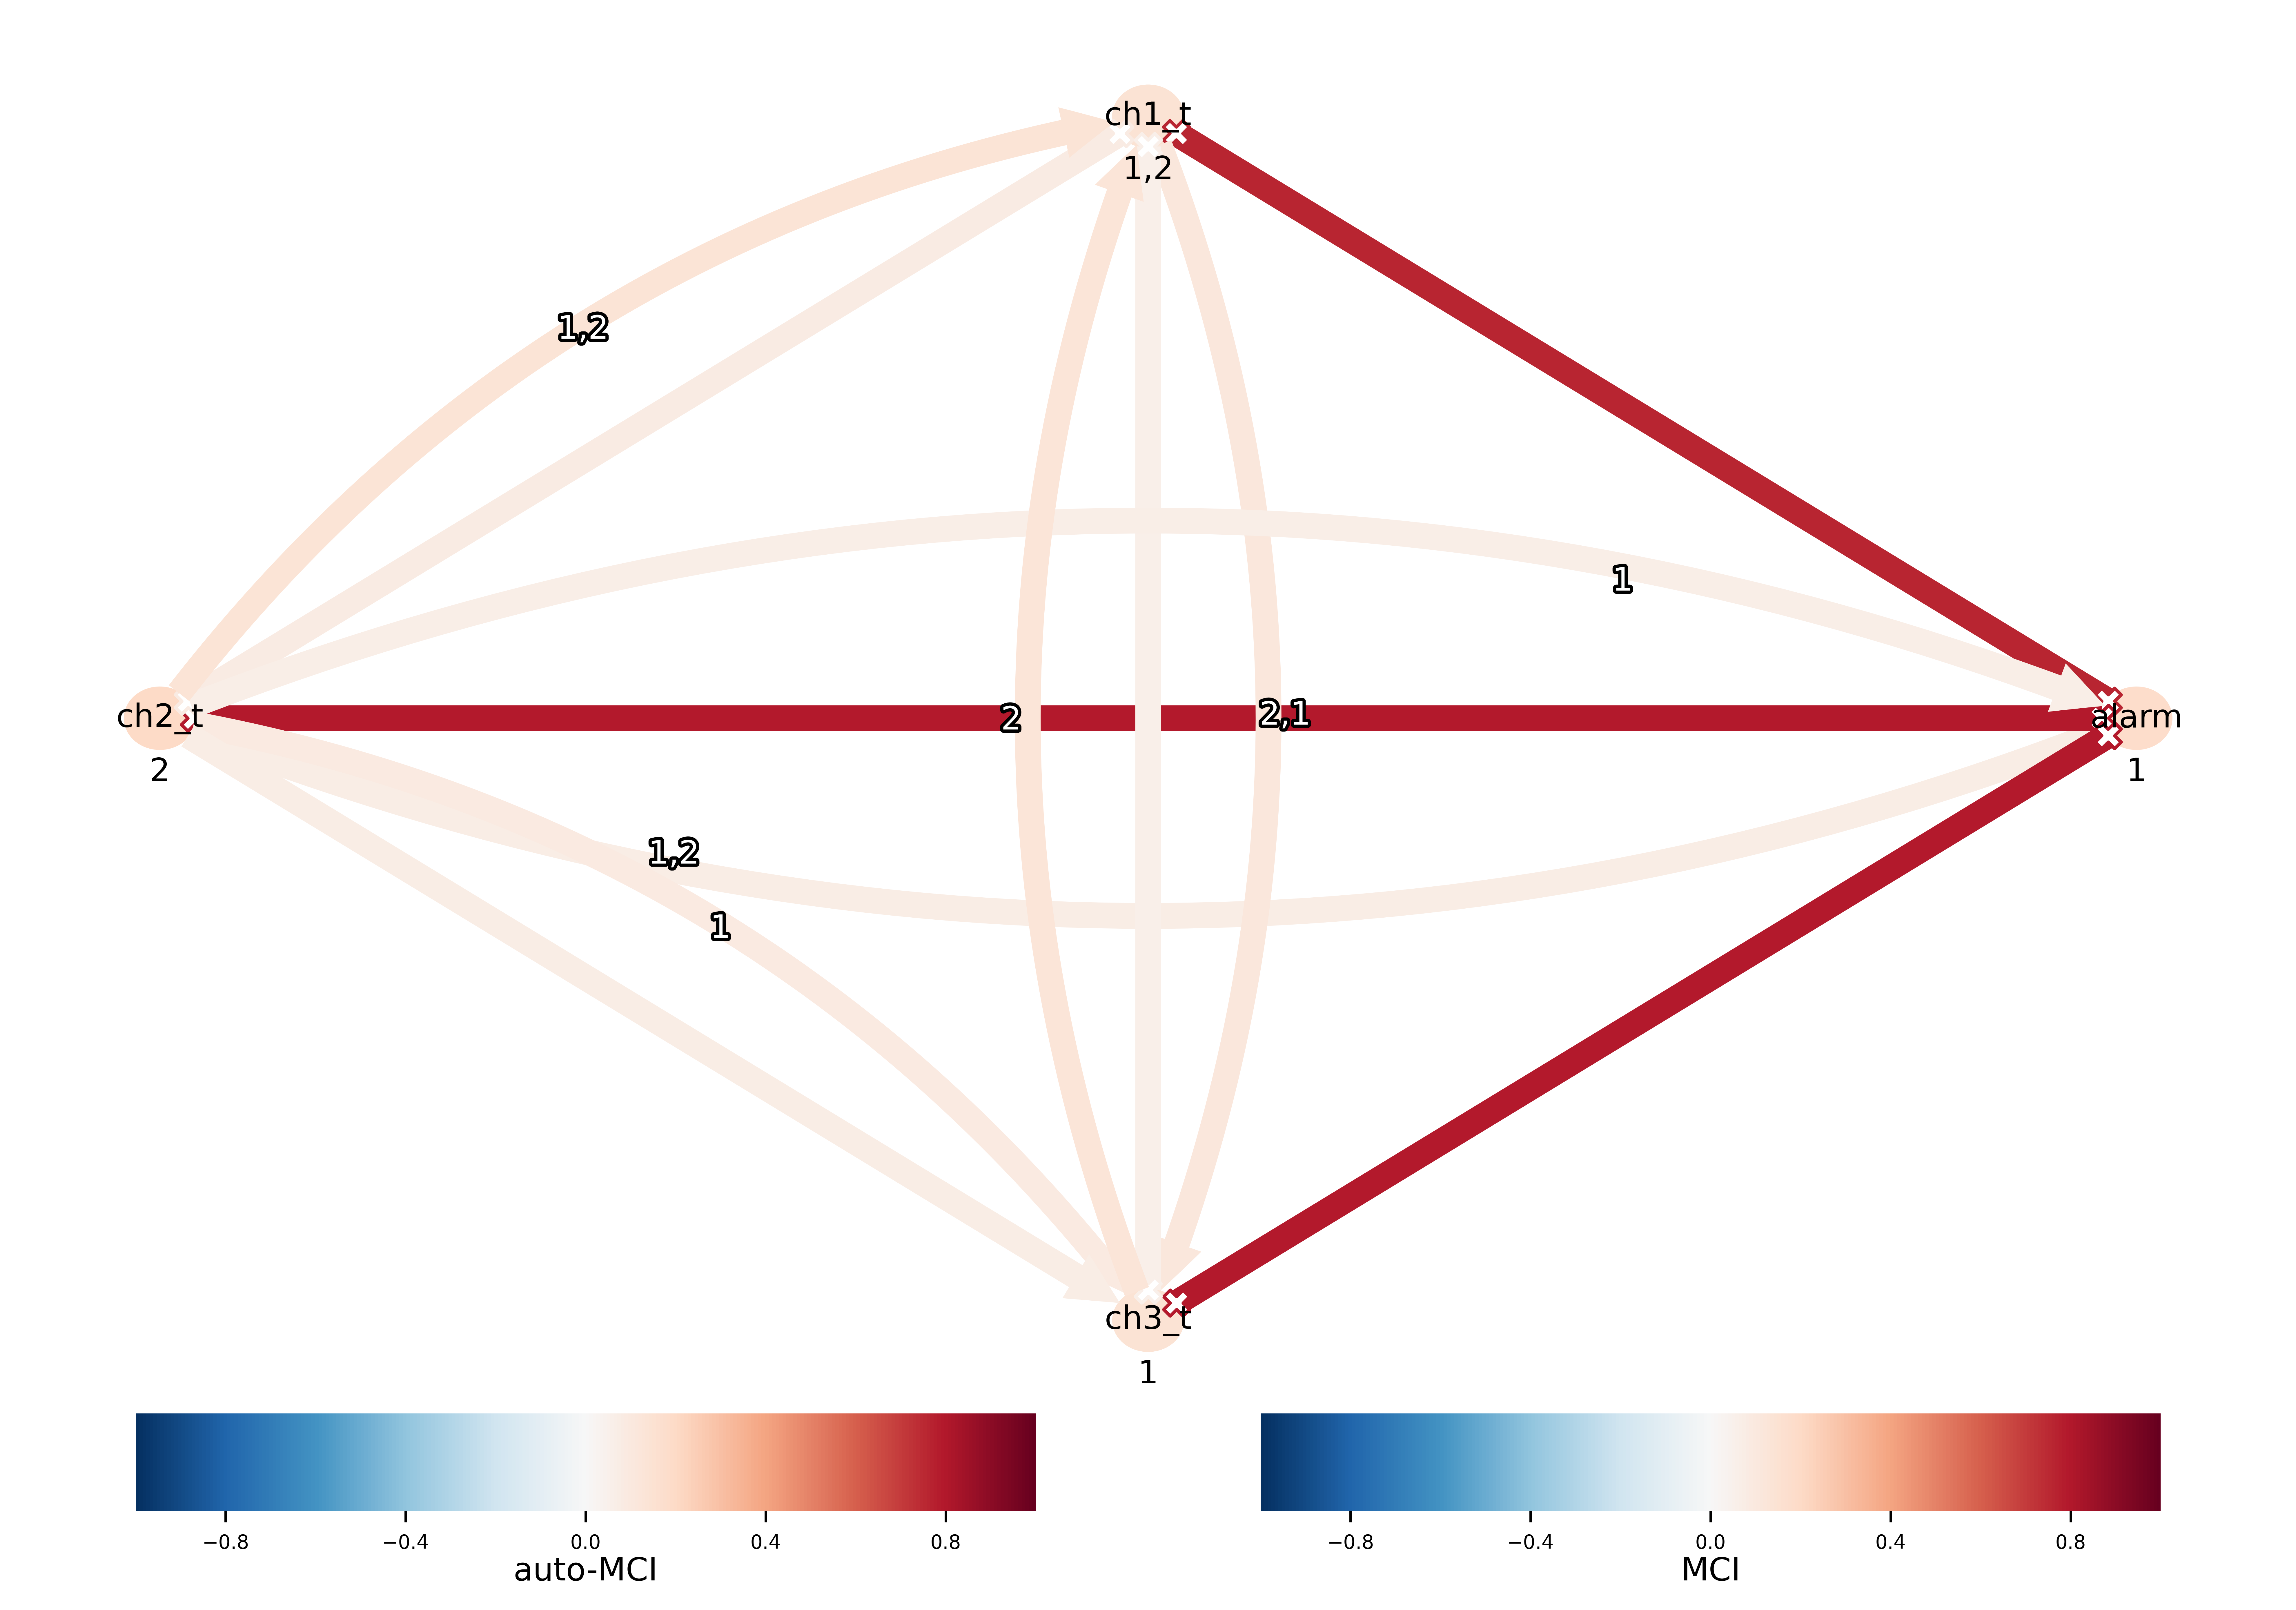

In [7]:
time_serie = pp.DataFrame(flattened_data.astype("float64"), datatime = {0:np.arange(len(flattened_data))}, var_names = columns) #{0:np.arange(len(bin0))}

pvalues = [0.05, 0.03, 0.01]
ress = []
for pvalue in pvalues : 
    print(f"\nFor pvalue {pvalue} : \n")
    res = run_causal_discovery_pcmci(time_serie, columns, filename='pcmci_0', pvalue=pvalue)
    ress.append(res)



The resulting causal graph display fascinating results (From left to right, the complete causal graph, the causal graph without conflicting edges and the causal graph for only the connections above 0.2 MCI score).
- 1. Only 2nd order lag for the ch2 variable like originally in the ground truth graph and the data generating process.
- 2. The direct connections of the three different channels variables to the "alarm" variables (ch1, ch2, ch3).

- 3. Most of the connections between the different channel variables like : 

    - ch2_t1 ---> ch3, 
    - ch2_t1 ---> ch1 or 
    - ch3_t2 ---> ch1, etc... 

- 4. The connection ch3_t1 ---> ch2 is missing (only found a conflicting link between the two variables).

- 5. Three cycles, between (ch1 - ch3), (ch2 - alarm) and (ch3 - alarm), which could be representation limitations as much as computational limitations.





<div style="display: flex;">
    <div style="flex: 1;">
        <img src="pcmci_all.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_semi.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_directed.png" alt="alt text" style="width: 100%;"/>
    </div>
</div>


For pvalue 0.05 : 



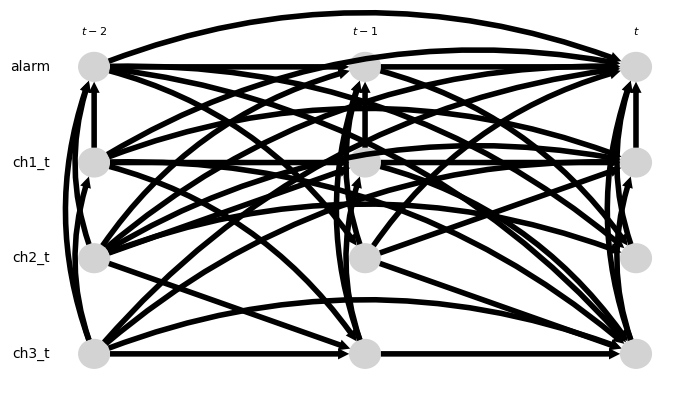


For pvalue 0.03 : 



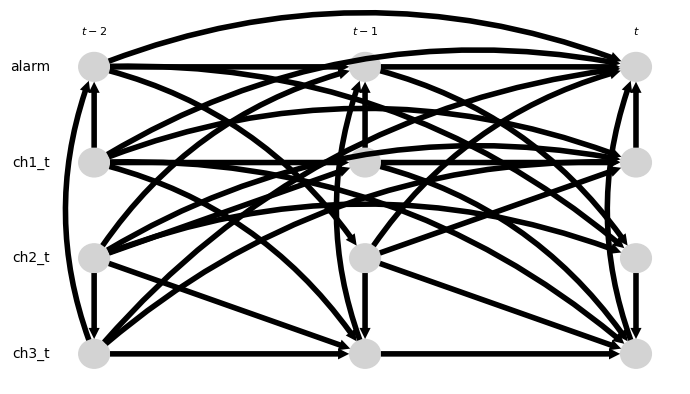


For pvalue 0.01 : 



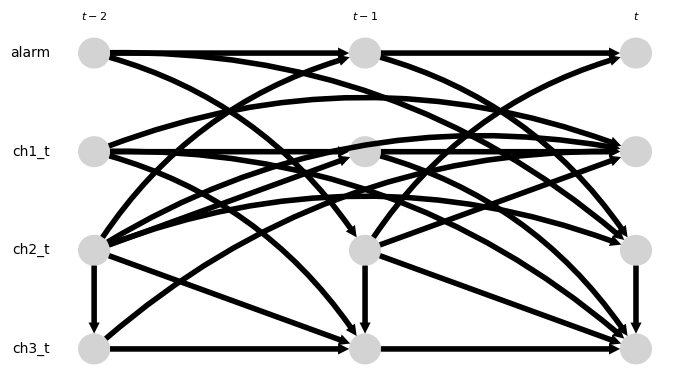

In [8]:

# Visualizing the timserie at directed edges level
#tp.plot_time_series_graph(graph=res['graph2'], var_names=columns, figsize=(7,4))
"""filename = "pcmci_timeserie_directed"
plt.savefig('./' + filename + '.png')
plt.tight_layout()
plt.show()"""

# Visualizing the timserie at all the edges level
#tp.plot_time_series_graph(graph=res['graph3'], var_names=columns, figsize=(7,4))
"""filename = "pcmci_timeserie_semi"
plt.savefig('./' + filename + '.png')
plt.tight_layout()
plt.show()"""


# Visualizing the timserie at all the edges level
timeseries = []
for i,res in enumerate(ress ): 
    print(f"\nFor pvalue {pvalues[i]} : \n")

    tp.plot_time_series_graph(graph=res['graph2'], var_names=columns, figsize=(7,4))
    filename = "pcmci_timeserie_all" +f"{pvalues[i]}"
    plt.savefig('./' + filename + '.png')
    plt.tight_layout()
    plt.show()



The corresponding timeserie graphs : 

<div style="display: flex;">
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.05.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.03.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.01.png" alt="alt text" style="width: 100%;"/>
    </div>
</div>

## Graph and Timeserie Causal discovery using PC Algorithm with time explicit variables

### Dataset modifications

In [9]:
import pandas as pd
import numpy as np

def define_time_depth_dataset(df, columns):
    # Copy the dataframe to avoid changing the original data
    df_dynamic = df.copy()

    # Loop through each specified column
    for col in columns:
        if col !='alarm': 

            """if col=="ch2_t" : 
                # Create new columns for lagged data at t-1 and t-2
                df_dynamic[f'{col}1'] = df_dynamic[col].shift(1)
                #df_dynamic[f'{col}_t-2'] = df_dynamic[col].shift(2)

                # Handle missing values by filling them with the next valid observation
                df_dynamic[f'{col}1'].fillna(method='bfill', inplace=True)
                #df_dynamic[f'{col}_t-2'].fillna(method='bfill', inplace=True)

            else : """
            # Create new columns for lagged data at t-1 and t-2
            df_dynamic[f'{col}1'] = df_dynamic[col].shift(1)
            df_dynamic[f'{col}2'] = df_dynamic[col].shift(2)

            # Handle missing values by filling them with the next valid observation
            df_dynamic[f'{col}1'].fillna(method='bfill', inplace=True)
            df_dynamic[f'{col}2'].fillna(method='bfill', inplace=True)

    return df_dynamic

# Usage
# Assuming 'df' is your DataFrame and you want to apply the transformation to these columns
df_t = df[["alarm", "ch1_t", "ch2_t","ch3_t"]]
columns_to_transform = df_t.columns 
print("Columns before exploding the variables over time : ", df_t.columns)
df_time = define_time_depth_dataset(df_t, columns_to_transform)
print("\nColumns after exploding the variables over time : ", df_time.columns)
df_time = df_time[["alarm",  "ch1_t",  "ch2_t",  "ch3_t", "ch1_t1", "ch2_t1" , "ch3_t1", "ch1_t2", "ch2_t2", "ch3_t2"]]

print("\n\nFirst rows' view of the new dataset : \n")
print(df_time.head())


Columns before exploding the variables over time :  Index(['alarm', 'ch1_t', 'ch2_t', 'ch3_t'], dtype='object')

Columns after exploding the variables over time :  Index(['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch1_t2', 'ch2_t1',
       'ch2_t2', 'ch3_t1', 'ch3_t2'],
      dtype='object')


First rows' view of the new dataset : 

   alarm  ch1_t  ch2_t  ch3_t  ch1_t1  ch2_t1  ch3_t1  ch1_t2  ch2_t2  ch3_t2
0      0      9     10     11     9.0    10.0    11.0     9.0    10.0    11.0
1      0      9     11     10     9.0    10.0    11.0     9.0    10.0    11.0
2      0     11      9     10     9.0    11.0    10.0     9.0    10.0    11.0
3      0      8      9      9    11.0     9.0    10.0     9.0    11.0    10.0
4      0      9      8      8     8.0     9.0     9.0    11.0     9.0    10.0


In [10]:
for c in df_time.columns : 
    df_time[c] = df_time[c].astype('float').astype('int')

print(df_time)
df_time.to_csv('data_time_fail.csv', index=False)

      alarm  ch1_t  ch2_t  ch3_t  ch1_t1  ch2_t1  ch3_t1  ch1_t2  ch2_t2  \
0         0      9     10     11       9      10      11       9      10   
1         0      9     11     10       9      10      11       9      10   
2         0     11      9     10       9      11      10       9      10   
3         0      8      9      9      11       9      10       9      11   
4         0      9      8      8       8       9       9      11       9   
...     ...    ...    ...    ...     ...     ...     ...     ...     ...   
9995      7     20     21     22      20      19      28      20      21   
9996      6     20     21     22      20      21      22      20      19   
9997      7     20     21     28      20      21      22      20      21   
9998      9     18     20     38      20      21      28      20      21   
9999      7     22     25     19      18      20      38      20      21   

      ch3_t2  
0         11  
1         11  
2         11  
3         10  
4         10

### Run PC 

Exploding the variables over time, and considering the time lag variables as exogenous variables to study the causal relationship with the PC algorithm while considering the temporal dimension. 

In [11]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph.GraphClass import CausalGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import gsq
import regex as re
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

In [49]:
## Run PC

dynamic_nodes = df_time.columns
exogeneous_nodes = ["ch1_t1", "ch2_t1" , "ch3_t1", "ch1_t2", "ch2_t2","ch3_t2"] #[x for x in dynamic_nodes if '_t' in str(x)]
rest_nodes = set(dynamic_nodes) - set(exogeneous_nodes)
print(len(dynamic_nodes), len(rest_nodes), len(exogeneous_nodes))


bk = BackgroundKnowledge()
for x in dynamic_nodes : 
    xg = GraphNode(x)
    for y in exogeneous_nodes : 
        yg = GraphNode(y)
        bk.add_forbidden_by_node(xg, yg)

for x in dynamic_nodes : 
        xg = GraphNode(x)
        bk.add_forbidden_by_node(GraphNode("alarm"), xg)

for x in exogeneous_nodes : 
        xg = GraphNode(x)
        bk.add_forbidden_by_node(xg, GraphNode("alarm"))


def run_pc(df_time, bk, pvalue) :
        cg = pc(data=df_time.values,
                alpha=pvalue,
                indep_test= "fisherz",#"gsq",#
                stable=True,
                uc_rule=0,
                uc_priority=2,
                mvpc=False,
                #correction_name='MV_Crtn_Fisher_Z',
                background_knowledge=bk,
                verbose=False,
                show_progress=True,
                node_names= df_time.columns,
                #cache_path="./cache_tmp.json",
                true_dag=None)

        print(df_time.columns)
        labels = list(df_time.columns)
        print(labels)
        cg.labels = labels
        g = cg.G

        pyd = GraphUtils.to_pydot(cg.G)
        pyd.write_png('./pc_time_fail' + f'{pvalue}' + '.png')
        return cg

pc_gs = []
for pvalue in pvalues : 
        pcg = run_pc(df_time, bk, pvalue)
        pc_gs.append(pcg)

10 4 6


  0%|          | 0/10 [00:00<?, ?it/s]

Index(['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1',
       'ch1_t2', 'ch2_t2', 'ch3_t2'],
      dtype='object')
['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1', 'ch1_t2', 'ch2_t2', 'ch3_t2']


  0%|          | 0/10 [00:00<?, ?it/s]

Index(['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1',
       'ch1_t2', 'ch2_t2', 'ch3_t2'],
      dtype='object')
['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1', 'ch1_t2', 'ch2_t2', 'ch3_t2']


  0%|          | 0/10 [00:00<?, ?it/s]

Index(['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1',
       'ch1_t2', 'ch2_t2', 'ch3_t2'],
      dtype='object')
['alarm', 'ch1_t', 'ch2_t', 'ch3_t', 'ch1_t1', 'ch2_t1', 'ch3_t1', 'ch1_t2', 'ch2_t2', 'ch3_t2']


<div style="display: flex;">
    <div style="flex: 1;">
        <img src="pc_time_fail.png" alt="alt text" style="width: 50%;"/>
    </div>
</div>

Overall correct results but seemingly switch between ch1 and ch3 positions

## Comparaison of the differents causal graphs

In [13]:
data_time = pd.read_csv('data_time_fail.csv')
data_time.head()

alarm  ch1_t  ch2_t  ch3_t  ch1_t1  ch2_t1  ch3_t1  ch1_t2  ch2_t2  ch3_t2
0      0      9     10     11       9      10      11       9      10      11
1      0      9     11     10       9      10      11       9      10      11
2      0     11      9     10       9      11      10       9      10      11
3      0      8      9      9      11       9      10       9      11      10
4      0      9      8      8       8       9       9      11       9      10

In [50]:
import pydotplus
from causallearn.graph.Graph import Graph

# Ground truth graph 
ground_truth_graph = dot.copy()
dotplus = pydotplus.graph_from_dot_data(ground_truth_graph.source)
print(type(dotplus)) # prints <class 'pydotplus.graphviz.Dot'>
# if graph doesn't have multiedges, use dotplus.set_strict(true)
ground_truth_graph = nx.nx_pydot.from_pydot(dotplus)
print(type(ground_truth_graph)) # prints <class 'networkx.classes.multidigraph.MultiDiGraph'>


def causal_learn_to_networkx(cg: Graph) -> nx.MultiDiGraph:
    """
    Convert a causallearn graph to a networkx graph.
    
    Args:
        cg (causallearn.graph.Graph): Causallearn graph instance.
    
    Returns:
        nx.MultiDiGraph: NetworkX MultiDiGraph instance.
    """
    nx_graph = nx.MultiDiGraph()

    # Add nodes
    for node in cg.get_nodes():
        nx_graph.add_node(node.get_name())

    # Add edges
    for edge in cg.get_graph_edges():
        u, v = edge.get_node1(), edge.get_node2()
        u_name = u.get_name()
        v_name = v.get_name()
        nx_graph.add_edge(u_name, v_name)

    return nx_graph

"""pc_bns =[]
for cg in pc_gs : 
    cg_ = cg.G
    pc_graph = causal_learn_to_networkx(cg_)
    pc_bns.append(pc_graph)
"""

<class 'pydotplus.graphviz.Dot'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>


/tmp/ipykernel_2859442/877568904.py:9: DeprecationWarning: nx.nx_pydot.from_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  ground_truth_graph = nx.nx_pydot.from_pydot(dotplus)


#### Converting the causal graphs to PyAgrum Bayesian Network (BN) format 

##### PC graph


For pvalue = 0.05 : 


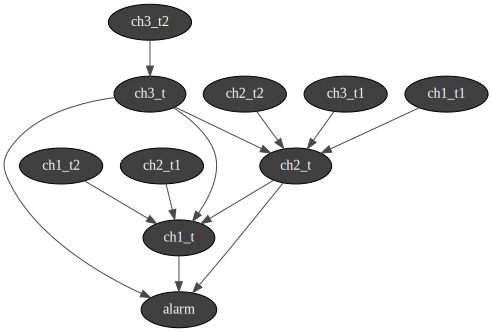


For pvalue = 0.03 : 


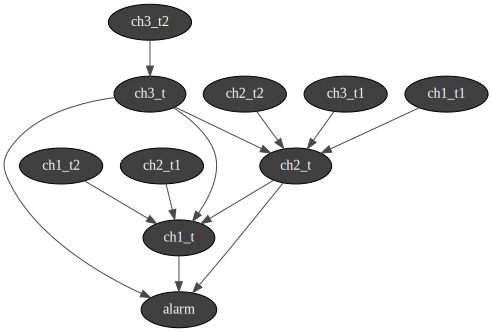


For pvalue = 0.01 : 


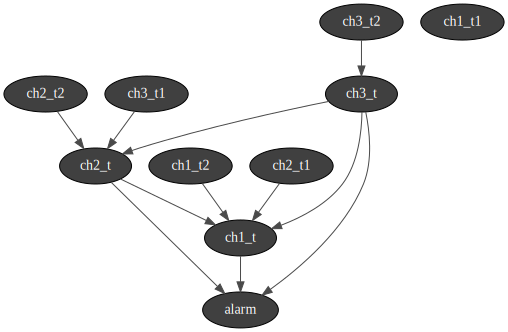

In [52]:
node_labels = ["alarm","ch1_t", "ch2_t", "ch3_t"]

import pyAgrum as gum
from causallearn.graph.Graph import Graph
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Endpoint import Endpoint
import pyAgrum.lib.notebook as gnb

def convert_to_bn(bnx: Graph, df_time):
    # Create a pyAgrum Bayesian network
    bng = gum.BayesNet("SampleBN")

    # Add nodes to the Bayesian network
    for node in bnx.get_nodes():
        node_name = node.get_name()
        num_unique_values = len(df_time[node_name].unique())
        bng.add(gum.LabelizedVariable(node_name, node_name, num_unique_values))

    # Add edges to the Bayesian network
    for edge in bnx.get_graph_edges():
        edge.get_node1
        u, v = edge.get_node1(), edge.get_node2()
        u_name = u.get_name()
        v_name = v.get_name()

        if edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.TAIL:
            bng.addArc(v_name, u_name)
        elif edge.get_endpoint2() == Endpoint.ARROW and edge.get_endpoint1() == Endpoint.TAIL:
            bng.addArc(u_name, v_name)
        elif edge.get_endpoint1() == Endpoint.ARROW and edge.get_endpoint2() == Endpoint.ARROW:
            # Handle bidirectional edge; assuming a single arc direction for now
            bng.addArc(u_name, v_name)
            bng.addArc(v_name, u_name)

    return bng

#graph_list = [cg.G]


bn_list = [convert_to_bn(bnx.G, df_time) for bnx in pc_gs]

for i,bn in enumerate(bn_list) : 
    print(f"\nFor pvalue = {pvalues[i]} : ")
    # Display the resulting Bayesian network
    gnb.showBN(bn, size=10)
    pc_bn = bn_list[0]


##### Ground Truth graph

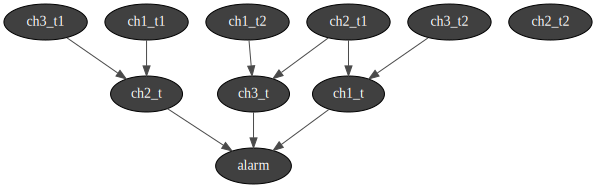

In [40]:
def get_range(df):
    desc = df.describe()
    desc = desc.loc[['min','max'],:].astype(int)
    desc.loc['min']=0
    return desc.to_dict('list')

#
ranges = get_range(df_time)
dot_graph = f""" ch1_t{ranges['ch1_t']} -> alarm;
ch2_t2;
ch2_t -> alarm;
ch3_t -> alarm;
ch1_t1 -> ch2_t;
ch2_t1 -> ch1_t;
ch2_t1 -> ch3_t;
ch3_t1 -> ch2_t;
ch1_t2 -> ch3_t;
ch3_t2 -> ch1_t
"""
gt_bn = gum.fastBN(dot_graph)
gnb.showBN(gt_bn,size=20)

##### PCMCI graphs

<div style="display: flex;">
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.01.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.03.png" alt="alt text" style="width: 100%;"/>
    </div>
    <div style="flex: 1;">
        <img src="pcmci_timeserie_all0.05.png" alt="alt text" style="width: 100%;"/>
    </div>
</div>

###### Pvalue : 0.05

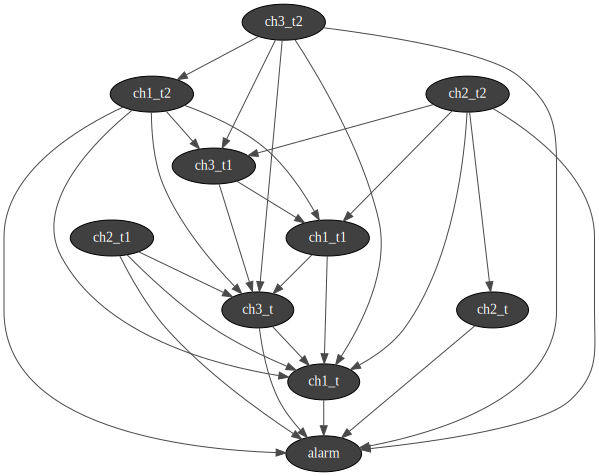

In [20]:
ranges = get_range(df_time)
dot_graph005 = f""" ch2_t -> alarm;
ch2_t2 -> ch1_t;
ch2_t2 -> ch1_t1;
ch2_t2 -> ch2_t;
ch2_t2 -> ch3_t1;
ch2_t2 -> alarm;
ch2_t1 -> alarm;
ch2_t1 -> ch1_t;
ch2_t1 -> ch3_t;
ch1_t2 -> ch1_t;
ch1_t2 -> ch1_t1;
ch1_t2 -> ch3_t;
ch1_t2 -> ch3_t1;
ch1_t2 -> alarm;
ch1_t1 -> ch1_t;
ch1_t1 -> ch3_t;
ch1_t -> alarm;
ch3_t2 -> ch3_t1;
ch3_t2 -> ch3_t;
ch3_t2 -> ch1_t;
ch3_t2 -> alarm;
ch3_t2 -> ch1_t2;
ch3_t1 -> ch3_t;
ch3_t1 -> ch1_t1;
ch3_t -> alarm;
ch3_t -> ch1_t
"""
gt_bn005 = gum.fastBN(dot_graph005)

gnb.showBN(gt_bn005,size=20)

###### Pvalue : 0.03

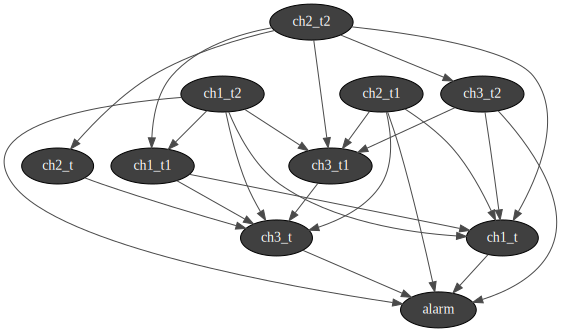

In [21]:
ranges = get_range(df_time)
dot_graph003 = f""" ch2_t -> ch3_t;
ch2_t2 -> ch1_t;
ch2_t2 -> ch1_t1;
ch2_t2 -> ch2_t;
ch2_t2 -> ch3_t1;
ch2_t2 -> ch3_t2;
ch2_t1 -> alarm;
ch2_t1 -> ch1_t;
ch2_t1 -> ch3_t;
ch2_t1 -> ch3_t1;
ch1_t2 -> ch1_t;
ch1_t2 -> ch1_t1;
ch1_t2 -> ch3_t;
ch1_t2 -> ch3_t1;
ch1_t2 -> alarm;
ch1_t1 -> ch1_t;
ch1_t1 -> ch3_t;
ch1_t -> alarm;
ch3_t2 -> ch3_t1;
ch3_t2 -> ch1_t;
ch3_t2 -> alarm;
ch3_t1 -> ch3_t;
ch3_t -> alarm
"""
gt_bn003 = gum.fastBN(dot_graph003)

gnb.showBN(gt_bn003,size=20)

###### Pvalue : 0.01

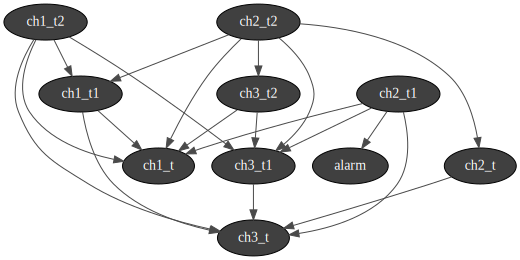

In [22]:

ranges = get_range(df_time)
dot_graph001 = f""" ch2_t -> ch3_t;
ch2_t2 -> ch1_t;
ch2_t2 -> ch1_t1;
ch2_t2 -> ch2_t;
ch2_t2-> ch3_t1;
ch2_t2 -> ch3_t2;
ch2_t1 -> alarm;
ch2_t1 -> ch1_t;
ch2_t1 -> ch3_t;
ch2_t1 -> ch3_t1;
ch1_t2 -> ch1_t;
ch1_t2 -> ch1_t1;
ch1_t2 -> ch3_t;
ch1_t2 -> ch3_t1;
ch1_t1-> ch1_t;
ch1_t1 -> ch3_t;
ch3_t2 -> ch3_t1;
ch3_t2 -> ch1_t;
ch3_t1 -> ch3_t
"""
gt_bn001 = gum.fastBN(dot_graph001)

gnb.showBN(gt_bn001,size=20)

#### Computing Visual differences between the Ground truth graph and obtained causal graphs - Computing Hamming distance and Structural Hamming Distance between the Ground truth graph and the PC Algorithm graph 

This method will return a graph that compares the arcs of _bn1 (reference) with those of self._bn2. 

- A full black line: the arc is common for both 
- A full red line: the arc is common but inverted in _bn2 
- A dotted black line: the arc is added in _bn2 
- A dotted red line: the arc is removed in _bn2

<div style="display: flex;">
    <div style="flex: 1;">
        <img src="graph_comp_results.png" alt="alt text" style="width: 70%;"/>
    </div>
</div>


Hamming distance is the difference of edges comparing the 2 skeletons, and Structural Hamming difference is the difference comparing the cpdags, including the arcs’ orientation.

[(pyAgrum.BayesNet<double>@0x5b56b40) BN{nodes: 10, arcs: 9, domainSize: 30208, dim: 482, mem: 5Ko 768o}
 (pyAgrum.BayesNet<double>@0x40fcb80) BN{nodes: 10, arcs: 19, domainSize: 1024, dim: 93, mem: 1Ko 464o}
 (pyAgrum.BayesNet<double>@0x451c0d0) BN{nodes: 10, arcs: 23, domainSize: 1024, dim: 123, mem: 1Ko 944o}
 (pyAgrum.BayesNet<double>@0x4b98410) BN{nodes: 10, arcs: 26, domainSize: 1024, dim: 247, mem: 3Ko 880o}
 (pyAgrum.BayesNet<double>@0x4d10780) BN{nodes: 10, arcs: 12, domainSize: 10^16.0592, dim: 438960610, mem: 3Go 352Mo 28Ko 192o}
 (pyAgrum.BayesNet<double>@0x4130010) BN{nodes: 10, arcs: 12, domainSize: 10^16.0592, dim: 438960610, mem: 3Go 352Mo 28Ko 192o}
 (pyAgrum.BayesNet<double>@0x4cb70e0) BN{nodes: 10, arcs: 11, domainSize: 10^16.0592, dim: 215454178, mem: 1Go 658Mo 540Ko 192o}]


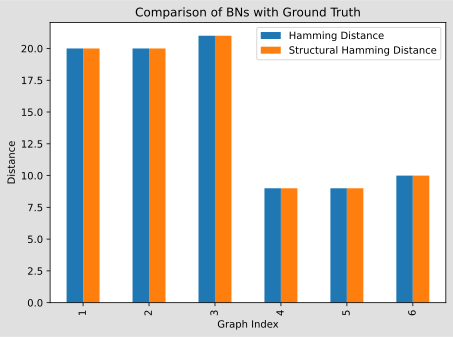

   Graph Index   Graph name  Hamming Distance  Structural Hamming Distance
0            1    pcmci_001                20                           20
1            2    pcmci_003                20                           20
2            3    pcmci_005                21                           21
3            4  pc_grath001                 9                            9
4            5  pc_grath003                 9                            9
5            6  pc_grath005                10                           10


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import pyAgrum as gum
from pyAgrum.lib.bn_vs_bn import GraphicalBNComparator

import networkx as nx

def compare_bn_graphs(bn_list, graph_name_list, doc):
    # Extract the ground truth graph
    gt_bn = bn_list[0]

    results = []

    for i, bn in enumerate(bn_list[1:], start=1):
        gc = GraphicalBNComparator(gt_bn, bn, delta=1e-6)
        pydot_comp = gc.dotDiff()

        # Save the graph to a file
        pydot_comp.write(doc + "comp_graph_" + f"{graph_name_list[i]}" + ".pdf", format="pdf")

        hamming_dist, structural_hamming_dist = gc.hamming()['hamming'],  gc.hamming()['structural hamming'] # extract the numerical value
        results.append({
            "Graph Index": i,
            "Graph name" : graph_name_list[i],
            "Hamming Distance": hamming_dist,
            "Structural Hamming Distance": structural_hamming_dist
        })

    # Convert results to a dataframe
    df = pd.DataFrame(results)

    # Save to CSV file
    df.to_csv(doc + "bn_comparisons.csv", index=False)

    # Plot the results
    fig, ax = plt.subplots()
    df.plot(kind='bar', x='Graph Index', y=['Hamming Distance', 'Structural Hamming Distance'], ax=ax)
    ax.set_xlabel("Graph Index")
    ax.set_ylabel("Distance")
    ax.set_title("Comparison of BNs with Ground Truth")
    plt.tight_layout()
    plt.show()

    return df


graph_list= [gt_bn, gt_bn001, gt_bn003, gt_bn005]
all_list = np.concatenate([graph_list,bn_list])
print(all_list)
graph_name_list= ["ground_truth_graph", "pcmci_001", "pcmci_003", "pcmci_005", "pc_grath001", "pc_grath003","pc_grath005"]

df = compare_bn_graphs(all_list, graph_name_list, doc="./comparaison/")
print(df)


Between the PCMCI results

#### Extending Ground truth understanding

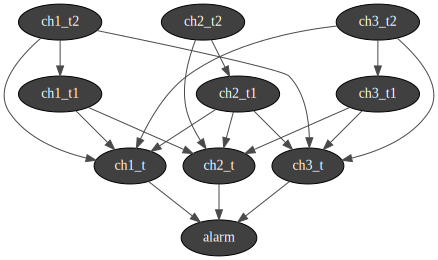

In [45]:
dot_graph_ext = f""" ch1_t-> alarm;
ch2_t2;
ch1_t1 -> ch1_t;
ch1_t2 -> ch1_t;
ch1_t2 -> ch1_t1;
ch2_t1 -> ch2_t;
ch2_t2 -> ch2_t;
ch2_t2 -> ch2_t1;
ch3_t1 -> ch3_t;
ch3_t2 -> ch3_t;
ch3_t2 -> ch3_t1;
ch2_t -> alarm;
ch3_t -> alarm;
ch1_t1 -> ch2_t;
ch2_t1 -> ch1_t;
ch2_t1 -> ch3_t;
ch3_t1 -> ch2_t;
ch1_t2 -> ch3_t;
ch3_t2 -> ch1_t
"""




gt_bn_ext = gum.fastBN(dot_graph_ext)
gnb.showBN(gt_bn_ext,size=20)

[(pyAgrum.BayesNet<double>@0x5b484b0) BN{nodes: 10, arcs: 18, domainSize: 1024, dim: 65, mem: 1Ko 16o}
 (pyAgrum.BayesNet<double>@0x40fcb80) BN{nodes: 10, arcs: 19, domainSize: 1024, dim: 93, mem: 1Ko 464o}
 (pyAgrum.BayesNet<double>@0x451c0d0) BN{nodes: 10, arcs: 23, domainSize: 1024, dim: 123, mem: 1Ko 944o}
 (pyAgrum.BayesNet<double>@0x4b98410) BN{nodes: 10, arcs: 26, domainSize: 1024, dim: 247, mem: 3Ko 880o}
 (pyAgrum.BayesNet<double>@0x4d10780) BN{nodes: 10, arcs: 12, domainSize: 10^16.0592, dim: 438960610, mem: 3Go 352Mo 28Ko 192o}
 (pyAgrum.BayesNet<double>@0x4130010) BN{nodes: 10, arcs: 12, domainSize: 10^16.0592, dim: 438960610, mem: 3Go 352Mo 28Ko 192o}
 (pyAgrum.BayesNet<double>@0x4cb70e0) BN{nodes: 10, arcs: 11, domainSize: 10^16.0592, dim: 215454178, mem: 1Go 658Mo 540Ko 192o}]


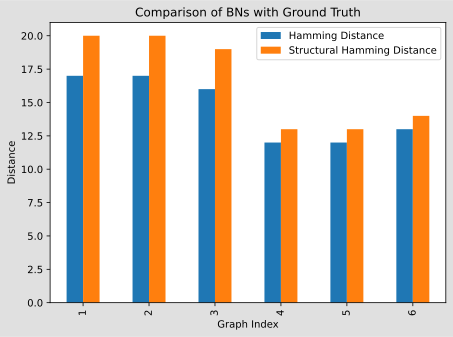

   Graph Index   Graph name  Hamming Distance  Structural Hamming Distance
0            1    pcmci_001                17                           20
1            2    pcmci_003                17                           20
2            3    pcmci_005                16                           19
3            4  pc_grath001                12                           13
4            5  pc_grath003                12                           13
5            6  pc_grath005                13                           14


In [56]:
graph_list= [gt_bn_ext, gt_bn001, gt_bn003, gt_bn005]
all_list = np.concatenate([graph_list,bn_list])
print(all_list)
graph_name_list= ["ground_truth_graph_extend", "pcmci_001", "pcmci_003", "pcmci_005", "pc_grath001", "pc_grath003","pc_grath005"]

df_ext = compare_bn_graphs(all_list, graph_name_list, doc="./comparaison_ext/")
print(df_ext)